# Ótimização de Custos de plano de saúde

## Contextualização e objetivos

Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente.

 

A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de cigarros.

 

Com base nessas informações, temos como objetivos encontrar as seguintes respostas:

 

1.     Quais fatores estão mais relacionados com o Custo do Plano de Saúde na empresa?

 

2.     Que tipo de ações preventivas a empresa pode fazer de forma a diminuir esse custo?

A base possui as seguintes variaveis:

- Idade - Idade do colaborador (Quantitativa)
- Sexo - Sexo do colaborador (Qualitativa)
- IMC - Índice de Massa Corporal do colaborador (Quantitativa)
- Qte_Filhos - 	Qte de filhos que o colaborador tem (Quantitativa)
- Fumante - Flag se o colaborador é fumante ou não fumante (Qualitativa)
- Região - Região do Brasil onde o colaborador mora (Qualitativa)
- Custo_Saude - Custo de Plano de Saúde que esse colaborador tem (Quantitativa)

Vamos começar conhecendo e explorando os dados que temos em mãos.

In [1]:
# pacotes de manipulação de dados
import pandas as pd
import numpy as np

#pacote de graficos
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# pacotes de tecnicas estatisticas
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


## Análise descritiva

In [2]:
df = pd.read_excel('base_plano_de_saude.xlsx', sheet_name = 'base')
df.head()

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude
0,19,Feminino,27.900,0,Sim,Centro,1688.492400
1,18,Masculino,33.770,1,Não,Sudeste,172.555230
2,28,Masculino,33.000,3,Não,Sudeste,444.946200
3,33,Masculino,22.705,0,Não,Norte,2198.447061
4,32,Masculino,28.880,0,Não,Norte,386.685520


Dentro da amostra coletada podemos observar:

- Há colaboradores entre 18 a 64 anos. Sendo que metade possui mais que 39 anos;
- Apenas cerca de 20% dos colaboradores estão dentro do peso considerado normal, enquanto os outros 80% apresentam algum nível de desvio. Desses 80%, 29% estão classificados com sobrepeso, e o restante é afetado por diferentes graus de obesidade;  
- Há colaboradores que tem 5 filhos, assim como há colaboradores que não tem filhos;
- O custo médio do plano de saúde é de `R$ 1327,04`. Metade dos colaboradores custam menos que `R$ 938,200`, porém há colaborados custando `R$ 6377,04`.

In [3]:
df.describe()

,Idade,IMC,Qte_Filhos,Custo_Saude
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,1327.042227
std,14.049960,6.098187,1.205493,1211.001124
min,18.000000,15.960000,0.000000,112.187390
25%,27.000000,26.296250,0.000000,474.028715
50%,39.000000,30.400000,1.000000,938.203300
75%,51.000000,34.693750,2.000000,1663.991252
max,64.000000,53.130000,5.000000,6377.042801


## Análise exploratória



O histograma é uma ferramenta poderosa para visualizar padrões, tendências e variações em um conjunto de dados, permitindo uma compreensão rápida
             e intuitiva da distribuição dos valores. O histograma abaixo mostra como está a distribuição do custo do plano de saúde dos colaboradores, no
            gráfico podemos observar que grande parte dos colaboradores tem um custo abaixo dos `R$ 1000,00`, e estão bem distruidos até os `R$ 2000,00` com alguns
        poucos acima dos R$ 4000,00.

C:\Users\Ben-Hur\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


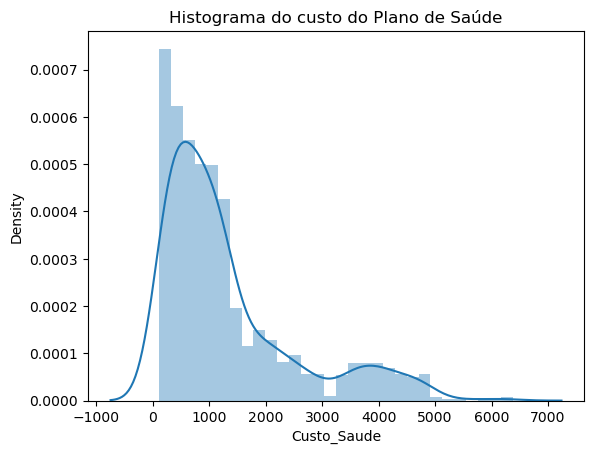

In [15]:
sns.distplot(df['Custo_Saude']);
plt.title('Histograma do custo do Plano de Saúde')

plt.savefig("graficos/hist_custo_saude.jpeg")

In [5]:
df1 = df.copy()

# Definir os limites dos grupos de idades
limites = [18, 28, 39, 50, 65]

# Definir os rótulos dos grupos de idades
rotulos = ['18 - 28', '29 - 39', '40 - 50', '51+']

# Criar uma nova coluna no dataframe com os grupos de idades
df1['Idade_Cat'] = pd.cut(df1['Idade'], bins=limites, labels=rotulos, right=False)

idade_cat = df1.groupby('Idade_Cat')['Custo_Saude'].sum().reset_index().round(2)
idade_cat = idade_cat.rename(columns = {'Custo_Saude': 'Frequencia'})
idade_cat['Frequencia Relativa'] = (idade_cat['Frequencia']/idade_cat['Frequencia'].sum() * 100).round(2)  
idade_cat['Frequencia Acumulada'] = idade_cat['Frequencia Relativa'].cumsum()

idade_cat

,Idade_Cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,18 - 28,329354.56,18.55,18.55
1,29 - 39,325796.30,18.35,36.90
2,40 - 50,431183.39,24.28,61.18
3,51+,689248.25,38.82,100.00


Como observado na análise descritiva, aproximadamente metade dos colaboradores desta amostra possui menos de 39 anos, o que poderia sugerir que a despesa do plano de saúde estaria igualmente distribuída nessa faixa etária. Entretanto, ao analisar a linha vermelha no gráfico abaixo, que indica o percentual acumulado de cada faixa etária, percebe-se que os grupos com menos de 39 anos gastam apenas 37% do total de recursos destinados ao plano de saúde. Isso indica uma distribuição desigual de custos, com outras faixas etárias contribuindo de forma mais significativa para o montante global. Essa análise destaca a importância de considerar diferentes grupos etários ao planejar os gastos do plano de saúde e pode oferecer insights para futuras estratégias de otimização e alocação de recursos.

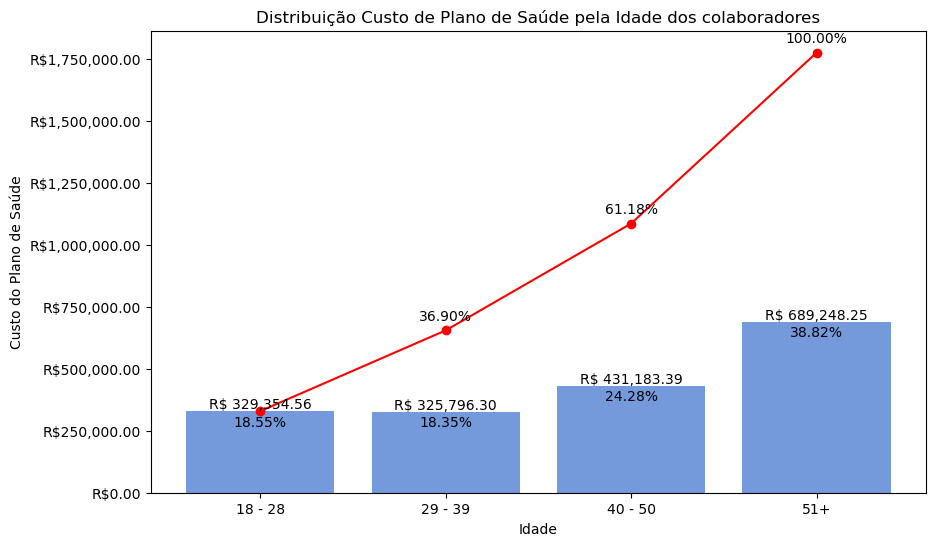

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Idade_Cat', y='Frequencia', data=idade_cat, color='cornflowerblue')

# Adicionar 'R$' nos valores do eixo y
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('R${x:,.2f}'))

# Add the percentages as text on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10000, f'R$ {height:,.2f}', ha='center')

# Add the percentage labels above the bars
for index, row in idade_cat.iterrows():
    plt.text(index, row['Frequencia'] - 60000, f'{row["Frequencia Relativa"]:.2f}%', ha='center')
    
    
# Adicionar linha de porcentagem acumulada com rótulos

plt.plot(ax.get_xticks(), idade_cat['Frequencia'].cumsum(), marker='o', color='red')
for index, value in enumerate(idade_cat['Frequencia'].cumsum()[1:]):
    plt.text(index+1, value + 40000, f'{idade_cat["Frequencia Acumulada"][index+1]:.2f}%', ha='center', color='black')


plt.xlabel('Idade')
plt.ylabel('Custo do Plano de Saúde')
plt.title('Distribuição Custo de Plano de Saúde pela Idade dos colaboradores')
#plt.grid(True)
#plt.xticks(rotation=45)

plt.savefig("graficos/custo_saudexidade.jpeg")
plt.show()


In [7]:
df2 = df.copy()
# Definir os limites dos grupos de idades
limites = [0,17, 18.49, 24.99, 29.99, 34.99, 39.9,  float('inf')]

# Definir os rótulos dos grupos de idades
rotulos = ['Muito abaixo do peso','Abaixo do peso', 'Peso normal', 'Sobrepeso', 'Obesidade grau I', 'Obesidade grau II', 'Obesidade grau III']

# Criar uma nova coluna no dataframe com os grupos de idades
df2['IMC_cat'] = pd.cut(df2['IMC'], bins=limites, labels=rotulos, right=False)

imc_cat = df2.groupby('IMC_cat')['Custo_Saude'].agg('sum').reset_index().round(2)
imc_cat = imc_cat.rename(columns = {'Custo_Saude': 'Frequencia'})
imc_cat['Frequencia Relativa'] = (imc_cat['Frequencia']/imc_cat['Frequencia'].sum() * 100).round(2)  
imc_cat['Frequencia Acumulada'] = imc_cat['Frequencia Relativa'].cumsum()

imc_cat_count = df2.groupby('IMC_cat')['Custo_Saude'].agg('count').reset_index().round(2)
imc_cat_count = imc_cat_count.rename(columns = {'Custo_Saude': 'Frequencia'})
imc_cat_count['Frequencia Relativa'] = (imc_cat_count['Frequencia']/imc_cat_count['Frequencia'].sum() * 100).round(2)  
imc_cat_count['Frequencia Acumulada'] = imc_cat_count['Frequencia Relativa'].cumsum() 
imc_cat_count

,IMC_cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,Muito abaixo do peso,3,0.22,0.22
1,Abaixo do peso,17,1.27,1.49
2,Peso normal,225,16.82,18.31
3,Sobrepeso,386,28.85,47.16
4,Obesidade grau I,391,29.22,76.38
5,Obesidade grau II,222,16.59,92.97
6,Obesidade grau III,94,7.03,100.00


In [8]:
imc_cat

,IMC_cat,Frequencia,Frequencia Relativa,Frequencia Acumulada
0,Muito abaixo do peso,1150.28,0.06,0.06
1,Abaixo do peso,16554.12,0.93,0.99
2,Peso normal,234210.10,13.19,14.18
3,Sobrepeso,424117.88,23.89,38.07
4,Obesidade grau I,563809.29,31.75,69.82
5,Obesidade grau II,375914.73,21.17,90.99
6,Obesidade grau III,159826.09,9.00,99.99


Como visto na análise descritiva anteriormente, cerca de 80% dos colaboradores estão acima do peso normal, é normal pensar que eles custariam mais para o plano de saúde. Como observado no gráfico abaixo eles custeam cerca de 85% do valor total, sendo que os colaboradores classificados com "Obesidade de grau I" são os mais custosos (31,75% da verba) entre eles.

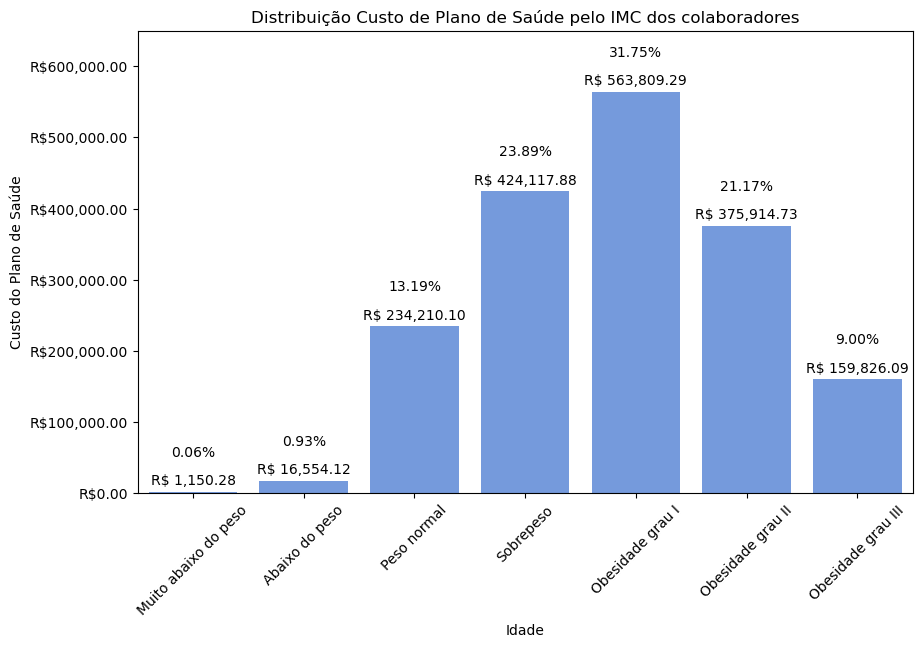

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='IMC_cat', y='Frequencia', data=imc_cat, color='cornflowerblue')

# Adicionar 'R$' nos valores do eixo y
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('R${x:,.2f}'))

# Add the percentages as text on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10000, f'R$ {height:,.2f}', ha='center')

# Add the percentage labels above the bars
for index, row in imc_cat.iterrows():
    plt.text(index, row['Frequencia'] + 50000, f'{row["Frequencia Relativa"]:.2f}%', ha='center')
    
    



plt.xlabel('Idade')
plt.ylabel('Custo do Plano de Saúde')
plt.ylim(0, 650000)
plt.title('Distribuição Custo de Plano de Saúde pelo IMC dos colaboradores')
#plt.grid(True)
plt.xticks(rotation=45)

plt.savefig("graficos/custo_saudeximc.jpeg")
plt.show()


O gráfico de boxplot é uma representação visual compacta e informativa que mostra a distribuição estatística de um conjunto de dados numéricos. Ele exibe a mediana, os quartis, a presença de outliers e a dispersão dos dados, permitindo uma rápida compreensão da distribuição e identificação de informações importantes, tornando-se uma ferramenta valiosa na análise exploratória de dados.

Abaixo temos alguns gráficos de boxplots relacionando para visualizar como está distribuida o Custo de Plano de Saúde com os fatores categoricos da base de dados ( Sexo do colaborador, Quantidade de filhos, Fumante e Região em que o colaborador vive)

No gráfico 1 comparando os custos do plano de saúde entre homens e mulheres. Vemos que as caixas estão no mesmo nível, indicando que não tem diferença no custo do plano, além de terem a mesma mediana próximo de `R$ 1000,00`, como visto na analise descritiva anteriormente.

No gráfico 2 estamos comparando o custo do plano de saúde com a quantidade de filhos dos colaboradores. Nele podemos observar que os colaboradores que possuem 5 filhos tem um custo mais concentrado em torno dos `R$ 1000,00`, contendo apenas um outlier que mal chega a custar `R$ 2000,00` para a empresa. Já colaboradores com menos que 5 filhos possam variar muito e chegar a custar `R$ 4000,00`, sem contar com os outliers chegando a mair de `R$ 6000,00`.

**No gráfico 3 observamos como os colaboradores fumantes custam mais para o plano de saúde do que para os colaboradores que não são fumantes.**

No gráfico 4 não vemos nenhuma região que custe mais para o plano de saúde.

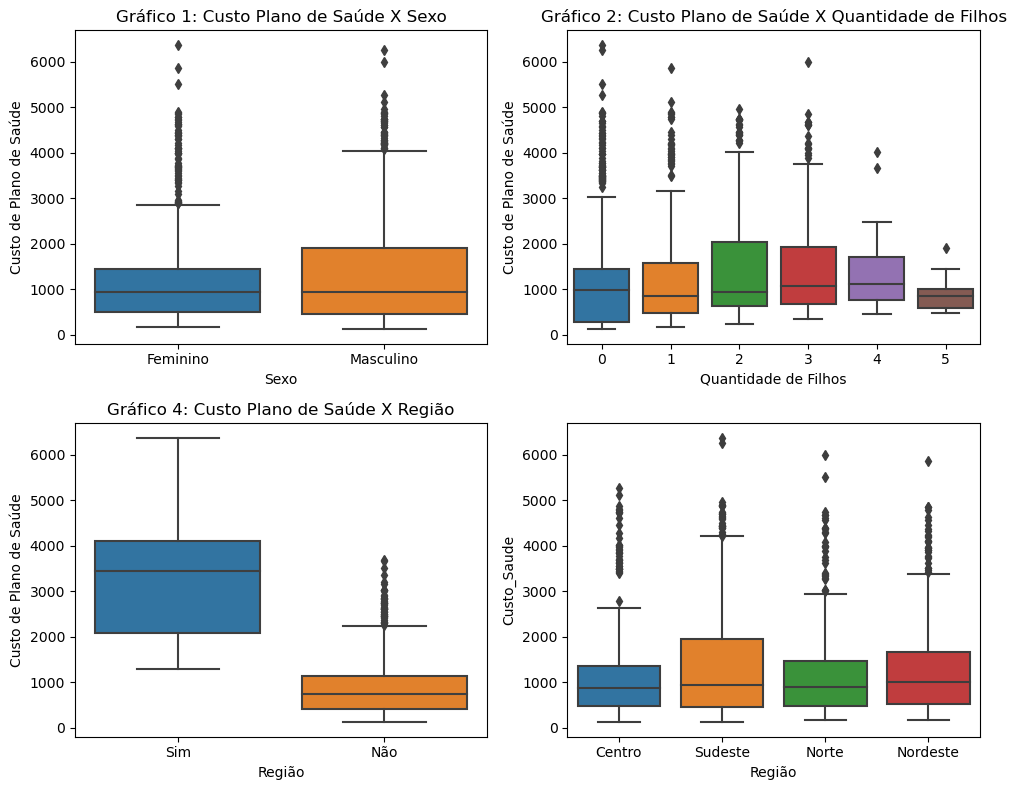

In [20]:
custo = df['Custo_Saude']
variaveis_quali = df[['Sexo', 'Qte_Filhos', 'Fumante', 'Região']]

data1 = df[['Custo_Saude', 'Sexo']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plota o primeiro boxplot na posição (0,0)
sns.boxplot(y = df['Custo_Saude'], x=df['Sexo'], ax=axes[0,0])
axes[0, 0].set_ylabel('Custo de Plano de Saúde')
axes[0, 0].set_xlabel('Sexo')
axes[0, 0].set_title('Gráfico 1: Custo Plano de Saúde X Sexo')

# Plota o segundo boxplot na posição (0,1)
sns.boxplot(y = df['Custo_Saude'], x=df['Qte_Filhos'], ax=axes[0,1])
axes[0, 1].set_ylabel('Custo de Plano de Saúde')
axes[0, 1].set_xlabel('Quantidade de Filhos')
axes[0, 1].set_title('Gráfico 2: Custo Plano de Saúde X Quantidade de Filhos')

# Plota o terceiro boxplot na posição (1,0)
sns.boxplot(y=df['Custo_Saude'], x=df['Fumante'], ax=axes[1, 0])
axes[1, 0].set_ylabel('Custo de Plano de Saúde')
axes[1, 0].set_xlabel('Fumante')
axes[1, 0].set_title('Gráfico 3: Custo Plano de Saúde X Fumante')

# Plota o quarto boxplot na posição (1,1)
sns.boxplot(y=df['Custo_Saude'], x=df['Região'], ax=axes[1, 1])
axes[1, 0].set_ylabel('Custo de Plano de Saúde')
axes[1, 0].set_xlabel('Região')
axes[1, 0].set_title('Gráfico 4: Custo Plano de Saúde X Região')

# Ajusta o layout para evitar sobreposição de títulos e rótulos
plt.tight_layout()

# Mostra a figura com os boxplots
plt.savefig("graficos/custo_saudexboxplot.jpeg")
plt.show()

## Correlação com o custo do plano de saúde

### Variáveis Numericas

Buscaremos entender como as variáveis explicativas se relacionam com o custo do planos de saúde, a fim de identificar padrões, tendências ou efeitos que possam ser relevantes para nossas análises ou tomadas de decisão. Na sessão anterior vimos alguns gráficos interagindo o Custo do plano de saúde (vamos chama-la de variável reposta) e as demais variáveis que chamaremos que variavéis explicativas. Nesses gráficos tiramos algumas conclusões sobre algumas variáveis estarem impactando com o custo do plano de saúde, mas não podemos fazer isto baseado apenas no visual, existem alguns testes estatísticos que usamos para comprovar a correlação entre elas. A correlação pode ser positiva, negativa ou neutra, e seu valor varia entre -1 e 1, indicando a força e a direção dessa associação.

É importante ressaltar que correlação não implica causalidade. A existência de uma correlação entre duas variáveis não garante que uma cause a outra. Elas podem estar relacionadas indiretamente ou serem influenciadas por uma terceira variável desconhecida.

Para correlacionar as variáveis numericas utilizaremos a correlação de Pearson, uma medida estatística que avalia a relação linear entre duas variáveis quantitativas. O coeficiente de correlação varia entre -1 e 1, onde -1 indica uma correlação negativa perfeita, 1 indica uma correlação positiva perfeita e 0 indica ausência de correlação. É amplamente utilizado em pesquisas científicas e análises estatísticas para examinar a associação entre variáveis contínuas. No entanto, a correlação não implica causalidade, e sua interpretação deve considerar a linearidade das relações e a sensibilidade a outliers

Abaixo vemos a representação dessa correlação com um mapa de calor. Ao observar a primeira linha onde está o "Custo do plano de saúde" observamos que ela quase não tem correlação com as demais variáveis, sendo a correlação com a "Quantidade de filhos" quase 0 (zero).

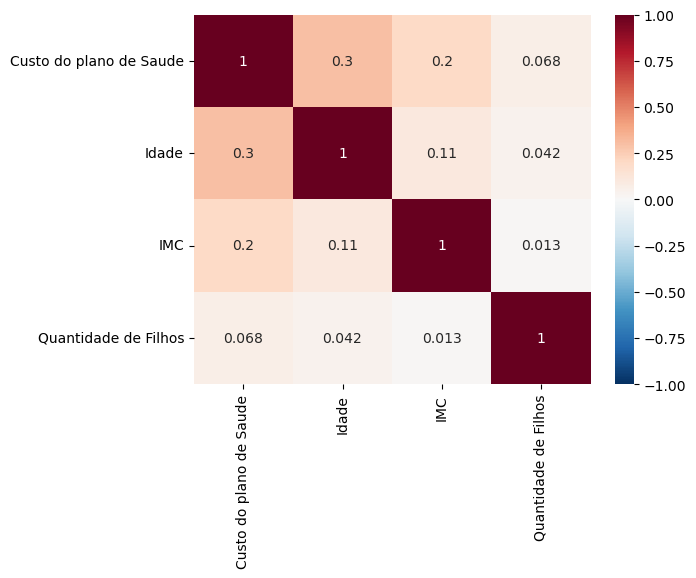

In [21]:
df_numerico = df.copy()
df_numerico = df_numerico[['Custo_Saude', 'Idade','IMC','Qte_Filhos']]
df_numerico = df_numerico.rename(columns = {'Custo_Saude': 'Custo do plano de Saude', 'Qte_Filhos': 'Quantidade de Filhos'})
sns.heatmap(df_numerico.corr(),
            cmap='RdBu_r', 
            vmin=-1, vmax=1, 
            annot=True);

plt.savefig("graficos/correlacao_numerica.jpeg")

### Variáveis Categóricas - Fumante

Para comparar se fumar aumenta o "Custo do plano de saúde" compararemos as médias de custos dos colaboradores "fumantes" e "não fumantes". Se a diferença dessas médias for significativamente diferente diremos que o custo do plano de saúde tem correlação com ser fumante, se não houver diferença significativa entre as médias não há correlação:

- Medias de custo do plano de saúde para colaboradores fumantes: `R$ 3205,02`.
- Medias de custo do plano de saúde para colaboradores **NÃO** fumantes: `R$ 843,42`

Observamos que colaboradores que fumam tem em média custos maiores que os que não fumam, mas será mesmo que esta diferença de custo é estatisticamente significativa? O teste t de Student é um teste estatístico paramétrico usado para comparar as médias de duas amostras independentes. Para realizar o teste t, compararemos as hipóteses:

1. Hipótese Nula (H0): As médias dos custos para o plano de saúde entre fumantes e não fumantes são significativamente iguais.

2. Hipótese Alternativa (H1):As médias dos custos para o plano de saúde entre fumantes e não fumantes são significativamente diferentes.

Para decidir se rejeitamos ou não a hipótese nula (H0), com base nos resultados do teste t, geralmente calculamos o valor-p. 
- Se o valor-p for menor que um nível de significância pré-determinado (geralmente 0,05 ou 0,01), rejeitamos a hipótese nula (H0). 
- Se o valor-p for maior que o nível de significância, não temos evidências suficientes para rejeitar H0, e não podemos afirmar com confiança que as médias das duas amostras são diferentes.

Não irei entrar em detalhes sobre os calculos, mas com da função *ttest_ind()* do pacote stats, encontramos um p-valor = 8,27. Com um p-valor > 0,05 temos evidências para rejeitar H0. Ou seja, **o colaborador fumar realmente implica em um aumento no valor do plano de Saúde.**


In [12]:
# Dividir os dados em dois grupos com base na variável "fumante"
grupo_fumante = df[df["Fumante"] == "Sim"]
grupo_nao_fumante = df[df["Fumante"] == "Não"]

# Realizar o teste de diferença de médias (usando o teste t de Student como exemplo)
resultado_teste = stats.ttest_ind(grupo_fumante["Custo_Saude"], grupo_nao_fumante["Custo_Saude"])

# Imprimir o resultado do teste
resultado_teste


Ttest_indResult(statistic=46.66492117272372, pvalue=8.271435842176277e-283)

### Variáveis Categóricas - IMC categórico

In [13]:
# Ajustando o modelo linear usando a ANOVA
modelo = ols('Custo_Saude ~ C(IMC_cat)', data=df2).fit()

# Obtendo a tabela ANOVA
tabela_anova = sm.stats.anova_lm(modelo, typ=2)

# Realizando o teste de Tukey
tukey_result = pairwise_tukeyhsd(df2['Custo_Saude'], df2['IMC_cat'])

# Exibindo os resultados
print(tabela_anova)


                  sum_sq      df          F        PR(>F)
C(IMC_cat)  9.136860e+07     6.0  10.842456  8.289688e-12
Residual    1.869374e+09  1331.0        NaN           NaN


In [14]:
# Exibindo os resultados do teste de Tukey
print(tukey_result)


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
       group1               group2         meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------------
      Abaixo do peso Muito abaixo do peso -590.3453 0.9854 -2781.7877 1601.0971  False
      Abaixo do peso     Obesidade grau I  468.1956 0.6859   -398.801 1335.1922  False
      Abaixo do peso    Obesidade grau II  719.5378 0.1939  -161.1017 1600.1773  False
      Abaixo do peso   Obesidade grau III  726.5057 0.2322  -195.7965 1648.8079  False
      Abaixo do peso          Peso normal   67.1619    1.0  -813.0599  947.3837  False
      Abaixo do peso            Sobrepeso  124.9791 0.9995  -742.2514  992.2097  False
Muito abaixo do peso     Obesidade grau I 1058.5409 0.7198  -969.6053 3086.6871  False
Muito abaixo do peso    Obesidade grau II  1309.883 0.4795  -724.1326 3343.8987  False
Muito abaixo do peso   Obesidade grau III  